# Lab Four: The Multi-Layer Perceptron

### *Harrison Noble & Henry Lambson*

___
 
In this lab, you will compare the performance of multi-layer perceptrons programmed via your own various implementations.

__Dataset Selection__

For this assignment, you will be using a specific dataset chosen by the instructor.  This is US Census data available on Kaggle, and also downloadable from the following link: https://www.dropbox.com/s/bf7i7qjftk7cmzq/acs2017_census_tract_data.csv?dl=0

The Kaggle description appears here: https://www.kaggle.com/muonneutrino/us-census-demographic-data/data 

The classification task you will be performing is to __predict, for each county, what the child poverty rate will be.__ You will need to convert this from regression to __four levels of classification__ by quantizing the variable of interest. 

___

## 1 Load, Split & Balance

### 1.1 Load Data & Save to Pandas Data Frame

We will start off by reading in the data into a dataframe, removing all rows with missing values, and visualizing the data after removing rows with missing values.

Text(0.5, 1.0, 'Missing data')

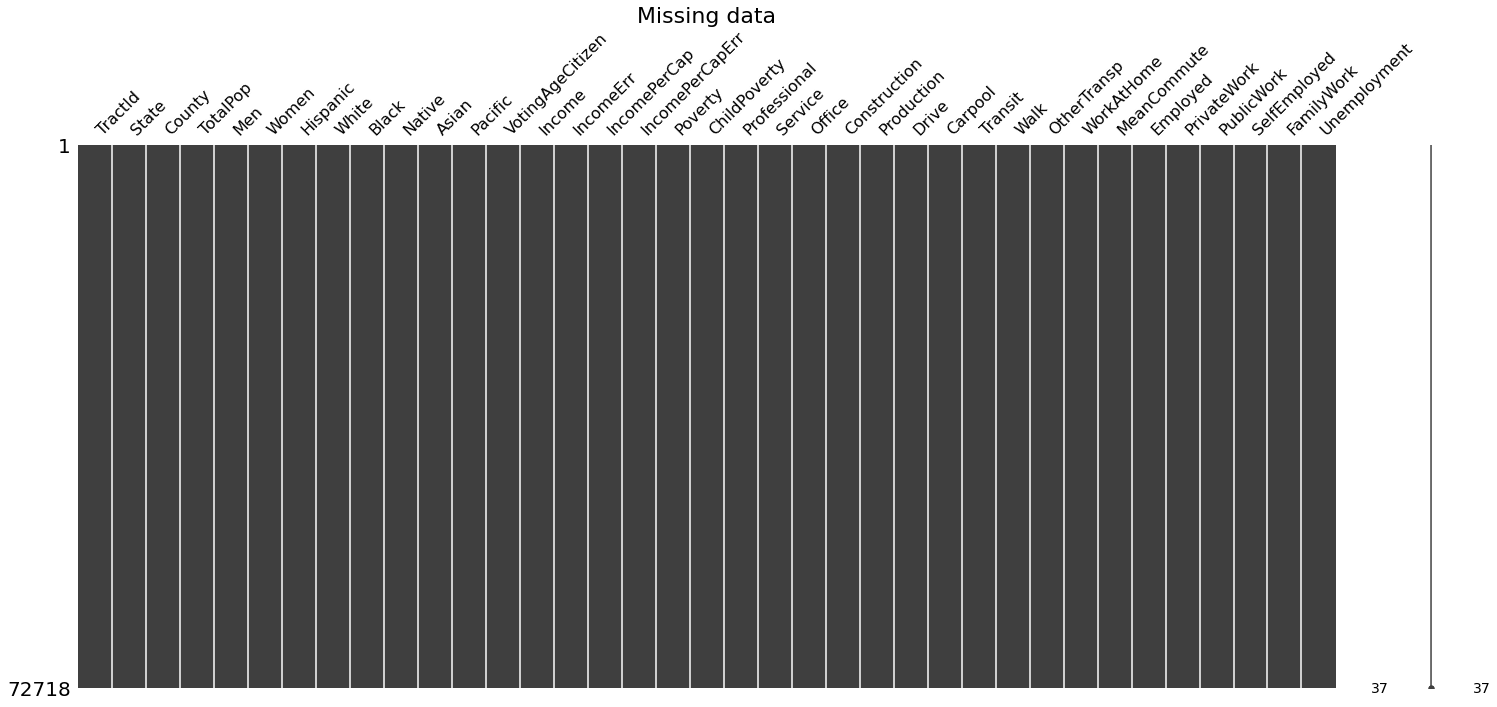

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
import missingno as mn
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 

#load data and drop all missing rows
df = pd.read_csv('acs2017_census_tract_data.csv')
df.dropna(inplace=True)

#visualize missingno plot to make sure no missing values
mn.matrix(df)
plt.title("Missing data",fontsize=22)

As we can see above from the missingno plot, we now have no missing values in our data. Additionally, from the above table and plot, we can see that there are a total of 37 features (including ChildPoverty which we will extract later) and 72718 instances in our dataset.

In [2]:
df.select_dtypes(include='object').columns

Index(['State', 'County'], dtype='object')

We can see that columns 'State' and 'County' need to be encoded as integers. Let's do that now. Let's also figure out all the columns we want to remove (aka not necessary in the X data), the columns with continuous data, and the columns with categorical data for ease of preprocessing in section 2.

In [3]:
from sklearn.preprocessing import LabelEncoder

#for every object datatype, encode as integer
for col in df.select_dtypes(include='object').columns:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

#columns to remove 
#(ChildPoverty b/c thats our prediction task, TractId b/c its not useful, and
#County b/c after running the nn with county still in the data, the nn couldnt converge)
remove = ["ChildPoverty", "TractId", "County"]
#categorical data
categories = ["State"]

#remove 'remove' columns then remove 'categories' columns
continuous = list(df[[col for col in list(df.columns) if col not in remove]])
continuous = [i for i in continuous if i not in categories]

### 1.2 Split Dataset

Now that our dataset consists of only numerical values, let's split the data into 80% for training and 20% for testing. Before we do this, we need to extract the child poverty rate from the dataframe and save it as our "y" value.

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np

#save child poverty rate as y
y = df.ChildPoverty
#drop 'remove' columns from df and save as X
X = df.drop(remove, axis=1)
#train test split
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(),
                                                    y.to_numpy(),
                                                    test_size=0.2,
                                                    random_state=1)

### 1.3 Balance Dataset

We now have the data split into testing and training sets. However, the child poverty rate is still a percentange ranging from 0-100%. We need to quantize the child poverty rate into 4 different classes. We also want to balance the dataset so about the same number of instances are within each class.

Lets first quantize the child poverty rate using the percentage value and visualize the instance distribution. For this we will use the following method to quantize the child poverty rate:
- child poverty rate <= 25%: Class 0 (very low child poverty)
- 25% < child poverty rate <= 50%: Class 1 (moderate child poverty)
- 50% < child poverty rate <= 75%: Class 2 (high child poverty)
- child poverty rate > 75%: Class 3 (very high child poverty)

Bins: [  0  25  50  75 100]
Number of instances in each class: [38217 14773  4507   677]


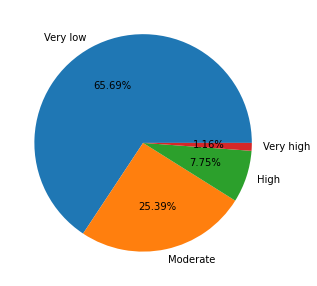

In [5]:
#quantize child poverty training set using above method
y_quant, bins = pd.cut(y_train,
                       bins=[0,25,50,75,100],
                       labels=[0,1,2,3],
                       retbins=True,
                       include_lowest=True)
print('Bins:', bins)

#output number of instances and plot
print('Number of instances in each class:',np.bincount(y_quant))
fig = plt.figure(figsize=(5, 5))
plt.pie(np.bincount(y_quant),
        labels=['Very low', 'Moderate', 'High', 'Very high'],
        autopct='%.2f%%')
plt.show()

This result is not great... we are not even close to balanced. By using the child poverty value we get about 65.5% in very low, 25.5% in moderate, 8% in high, and 1% in very high. If we wanted to balance our dataset using undersampling we would need to have 687 instances in each class (lowest number of class instances), which would remove about 95% of our data... not ideal. We could also oversample, which would add a lot of instances to the smaller classes (classes with lower amount of instances), but this would not accurately reflect our data as the numbers wont be real world statistics. We could also try a combination of both undersampling and oversampling techniques, however, this introduces a lot of overhead we have not learned so far.

Let's try a different method of quantizing the data. In this next method, we quantize the child poverty rate based on quartiles. Since we want to divide the child poverty rate into 4 classes, we can use quartile ranges to do so. To do this, we will use the following method to quantize the child poverty rate:
- child poverty rate <= Q1: Class 0 (very low child poverty)
- Q1 < child poverty rate <= Q2: Class 1 (moderate child poverty)
- Q2 < child poverty rate <= Q3: Class 2 (high child poverty)
- child poverty rate > Q3: Class 3 (very high child poverty)

Where each quartile (Q) represents 25% of the data

Bins: [  0.    6.2  16.4  31.7 100. ]
Number of instances in each class: [14589 14605 14502 14478]


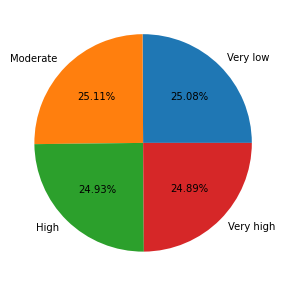

In [6]:
y_quant, bins = pd.qcut(y_train, 4, labels=[0,1,2,3], retbins=True)
print('Bins:', bins)

#output number of instances and plot
print('Number of instances in each class:',np.bincount(y_quant))
fig = plt.figure(figsize=(5, 5))
plt.pie(np.bincount(y_quant),
        labels=['Very low', 'Moderate', 'High', 'Very high'],
        autopct='%.2f%%')
plt.show()

This quantization is much more balanced. Looking at the bins, we can tell that each class is quantized in the following way:
- child poverty rate <= 6.2%: Class 0 (very low child poverty)
- 6.2% < child poverty rate <= 16.4%: Class 1 (moderate child poverty)
- 16.4% < child poverty rate <= 31.7%: Class 2 (high child poverty)
- child poverty rate > 31.7%: Class 3 (very high child poverty)

Looking at these numbers, we determined that this is an adequate way of quantizing the values. Since this method is looking at quartile ranges for the test child poverty values, we compared these quartile ranges with the entire dataset (using the first dataframe output in section 1.1). We deemed this quantization adequate since it accurately represents our dataset as a whole and the child poverty rate percentages this method split the data on seem like a good representation of census statistics [reference 2]. Because of this, we set our ```y_train``` variable equal to the ```y_quant``` variable for this quantization method below.

In [7]:
y_train = y_quant.to_numpy()
print(np.bincount(y_train))

[14589 14605 14502 14478]


__Should balancing of the dataset be done for both the training and testing set? Explain.__

In our case, we want to quantize the testing data using the same exact quatization method as the training data. In our case, we will set the bins to 0, 6.2, 16.4, 31.7, and 100. This will not necessarily result in balanced testing data as the testing data can have different quartile ranges, however, it will quantize our testing data using the exact same quartiles as our training data. We want to do this because any other method may result in testing data not being quantized in the same manner as our training data.

In general, balancing training data is a good idea as it trains the classifier in a way that reduces the risk of memorizing the class that occurs the most. This allows the classifier to "evenly" train across all classes of data. To answer the question if we should balance the testing dataset, the answer is usually no. If we want good generalization performace (that being good performance in the real world), we do not want to have balanced testing data. Real world data is not balanced and therefore not best represent our model. We should obviously use metrics like f-score, precision, and recall on our test data in order to assess the generalized performance on our model. 

The code below quantizes our testing data using the bins specified above:

Bins: [  0.    6.2  16.4  31.7 100. ]
Number of instances in each class: [3640 3728 3573 3603]


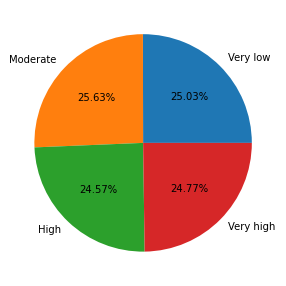

[3640 3728 3573 3603]


In [8]:
y_quant, bins = pd.cut(y_test, 
                       bins=[0, 6.2, 16.4, 31.7, 100.], 
                       labels=[0,1,2,3], 
                       retbins=True,
                       include_lowest=True)
print('Bins:', bins)

#output number of instances and plot
print('Number of instances in each class:',np.bincount(y_quant))
fig = plt.figure(figsize=(5, 5))
plt.pie(np.bincount(y_quant),
        labels=['Very low', 'Moderate', 'High', 'Very high'],
        autopct='%.2f%%')
plt.show()

#save y_quant to y_test
y_test = y_quant.to_numpy()
print(np.bincount(y_test))

Despite what we said above about not balancing the testing data, we need to be able to classify the testing data using the same ranges as our training. Because of this, the  testing data has become relatively balanced but not quite as balanced as our training data. We can see that there is about 0.5-1% more very low and moderate child poverty rates compared to high and very high child poverty rates in our testing set. In our training set, these percentages were much closer to eachother (within 0.25% at max). 

___

## 2 Pre-Processing

### 2.1 Use Example Two-Layer Perceptron Network & Quantify Performance

Below, we implement a two-layer perceptron class with vectorized computing, mini-batching, cross entropy, and Glorot initialization.

In [9]:
from scipy.special import expit
import sys

#implement base TwoLayerPerceptron class
#taken from 08. Practical_NeuralNets
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30, C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers"""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step"""
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation"""
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)  # last layer sensitivity
        V1 = A2*(1-A2)*(W2.T @ V2) # back prop the sensitivity 
        
        grad2 = V2 @ A2.T # no bias on final layer
        grad1 = V1[1:,:] @ A1.T # dont back prop sensitivity of bias
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [10]:
from sklearn.metrics import accuracy_score

#implement TwoLayerPerceptron class w/ mini batching
#taken from 08. Practical_NeuralNets
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data with mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                rho_W1, rho_W2 = eta * grad1, eta * grad2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

In [11]:
#implement TwoLayerPerceptron class w/ mini batching & cross entropy
#taken from 08. Practical_NeuralNets
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        '''Compute gradient step using backpropagation'''
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

In [12]:
#implement TLP class w/ mini batching, cross entropy & Glorot initialization
#taken from 08. Practical_NeuralNets
class TLPBetterInitial(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2

The massive chunk of code above creates the TLP with mini-batching, vectorized computation, cross entropy, and Glorot weight initialization (each new class definition builds off the previous ones). We decided to keep them seperate for clarity. 

Let's now test out the TLP implementation on the dataset and quantify the performance using accuracy.

In [13]:
#use print_result function from class to 
plt.style.use('ggplot')

def print_result(nn, X_train, y_train, X_test, y_test, title="", color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

In [14]:
#use params from class
vals = {'n_hidden':30, 
        'C':0.1, 'epochs':20, 'eta':0.001, 
        'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
        'shuffle':True, 'random_state':1}

nn1 = TLPBetterInitial(**vals)

%time nn1.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
print('Done!')

Epoch: 20/20

CPU times: user 14.2 s, sys: 9.36 s, total: 23.5 s
Wall time: 5.96 s
Done!


Unedited Data Loss :
Resubstitution acc: 0.2511087427373053
Validation acc: 0.2562568756875688


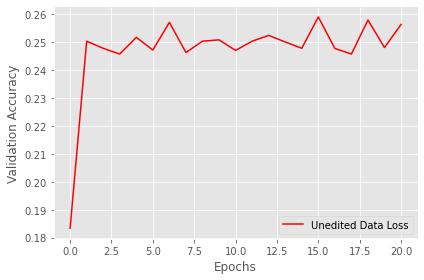

In [15]:
print_result(nn1, X_train, y_train, X_test, y_test,
             title="Unedited Data Loss")
plt.show()

This perceptron performs very poor. It's sitting around 25% accuracy after 20 epochs. We expected this due to the data not being normalized or one hot encoded whatsoever. Let's see how the model performs after normalizing continuous features now.

### 2.2 Normalize Continuous Numeric Feature Data

Here we use the sklearn StandardScaler to normalize all the continuous data. We then split that data into a train set and a test set (using the same random state as our first train-test-split in order to keep the ordering of the instances the same). We save the new train and test data into different variable names so we can compare all the models later. 

In [16]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

#normalize continuous features
X_normalized = X.copy()
X_normalized[continuous] = std_scaler.fit_transform(X_normalized[continuous])

#split normalized X data using same random state as first train test split
X_train_n, X_test_n = train_test_split(X_normalized.to_numpy(),
                                       test_size=0.2,
                                       random_state=1)

In [17]:
nn2 = TLPBetterInitial(**vals)

%time nn2.fit(X_train_n, y_train, print_progress=1, XY_test=(X_test_n, y_test))
print('Done!')

Epoch: 20/20

CPU times: user 12.4 s, sys: 8.18 s, total: 20.6 s
Wall time: 5.21 s
Done!


Normalized Data Loss :
Resubstitution acc: 0.5380238594561144
Validation acc: 0.5385038503850385


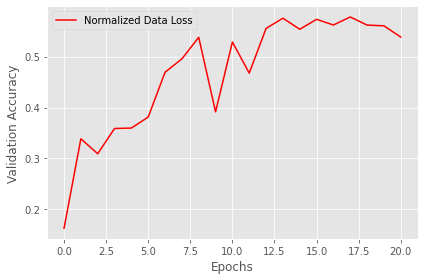

In [18]:
print_result(nn2, X_train_n, y_train, X_test_n, y_test,
             title="Normalized Data Loss")
plt.show()

That's what we like to see... improvement! This model is performing about 25-30% better than our previous model just by normalizing the continuous features. Let's see what normalization and one hot encoding can do for our accuracy.

### 2.3 One Hot Encode Categorical Data & Normalize Continuous Numeric Features

Lastly, we will one hot encode the categorical data. We do this by taking the normalized data, looping through the 'categories' list, and using the ```pd.get_dummies``` function to one hot encode those column(s). This data is also train-test-split (using the same random state as the previous two splits) and saved to seperate variables so we can compare in the next section. 

In [19]:
#copy over normalized data
X_norm_enc = X_normalized.copy()

for col in categories:
    X_norm_enc = pd.concat([X_norm_enc, pd.get_dummies(X_norm_enc[col], prefix=col)],
                           axis=1)
    X_norm_enc.drop([col], axis=1, inplace=True)

#split normalized & one hot X data using same random state as first train test split
X_train_ne, X_test_ne = train_test_split(X_norm_enc.to_numpy(),
                                         test_size=0.2,
                                         random_state=1)

In [20]:
nn3 = TLPBetterInitial(**vals)

%time nn3.fit(X_train_ne, y_train, print_progress=1, XY_test=(X_test_ne, y_test))
print('Done!')

Epoch: 20/20

CPU times: user 15.5 s, sys: 9.34 s, total: 24.9 s
Wall time: 6.33 s
Done!


Normalized & One Hot Encoded Data Loss :
Resubstitution acc: 0.722797125863788
Validation acc: 0.7283415841584159


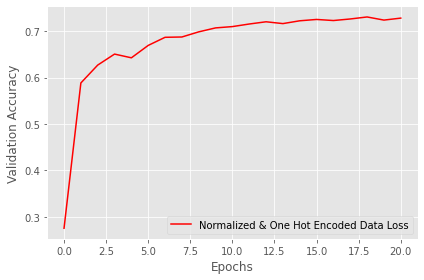

In [21]:
print_result(nn3, X_train_ne, y_train, X_test_ne, y_test,
             title="Normalized & One Hot Encoded Data Loss")
plt.show()

Wow! Both normalization and one hot encoding brought our accuracy way up to 72%. By just one hot encoding the 'State' feature, we were able to increase our accuracy another 20% compared to just normalizing continuous features.

### 2.4 Compare Performance of the Three Trained Models

Let's compare the performance of our three trained models below. We start off by graphing the accuracies of each one on the same plot as a visual reference.

Unedited Data Loss :
Resubstitution acc: 0.2511087427373053
Validation acc: 0.2562568756875688
Normalized Data Loss :
Resubstitution acc: 0.5380238594561144
Validation acc: 0.5385038503850385
Normalized & One Hot Encoded Data Loss :
Resubstitution acc: 0.722797125863788
Validation acc: 0.7283415841584159


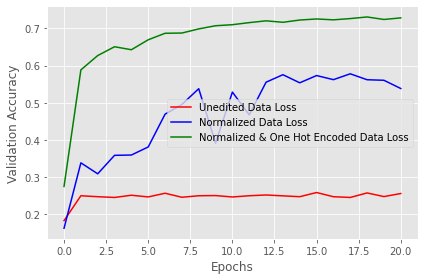

In [22]:
print_result(nn1, X_train, y_train, X_test, y_test,
             title="Unedited Data Loss", color='red')
print_result(nn2, X_train_n, y_train, X_test_n, y_test,
             title="Normalized Data Loss", color='blue')
print_result(nn3, X_train_ne, y_train, X_test_ne, y_test,
             title="Normalized & One Hot Encoded Data Loss", color='green')
plt.show()

Our three models have vastly different performances. Using the raw dataset (excluding the removed columns), the model was about as good as randomly picking a classification. We believe this is due to the nature of these numbers. With the raw dataset, there is very high variablility with each feature value. Because there is such a wide range, our first model struggles to actually learn.

Our second model performs better than our first model, however it does not perform great. This model is able to predict more accurately because the continuous data is normalized, which removes that high variability factor in each of the continuous features. Normalizing the continuous features removes the wide range which allows the model better learn since there are no continuous features "dominating" the others. However, there is still an issue with the 'State' feature since its value range (0-51) is much higher than the other data. This can introduce bias in the model, causing it to predict child poverty rates based on states.

To fix this, we must one hot encode state since it is categorical data. One hot encoding removes the wide value range in the 'State' feature by introducing more columns into the dataset (in our case 51 new columns). These new columns will contain all 0's except one column, which will contain a 1. By doing this, the model will no longer show bias towards the 'State' feature because that wide value range is reduced to 0 or 1. This caused our model to achieve around a 73% accuracy on the testing dataset, which is about 20% higher than the normalized data and about 50% higher than our raw data. 

We will now use the normalized and one hot encoded dataset for the remainder of the lab. We save the normalized and one hot encoded data to our ```X_train``` and ```X_test``` variables below:

In [23]:
X_train = X_train_ne
X_test = X_test_ne

___

## 3 Modeling

### 3.1 Add Support for Third Layer in Multi-Layer Perceptron

- __[1 points]__ Add support for a third layer in the multi-layer perceptron. Add support for saving (and plotting after training is completed) the average magnitude of the gradient for each layer, for each epoch. For magnitude calculation, you are free to use either the average absolute values or the L1/L2 norm. Quantify the performance of the model and graph the magnitudes for each layer versus the number of epochs.

In [23]:
#TODO

### 3.2 Add Support for Fourth Layer

- __[1 points]__ Repeat the previous step, adding support for a fourth layer.

In [24]:
#TODO

### 3.3 Add Support for Fifth Layer

- __[1 points]__ Repeat the previous step, adding support for a fifth layer. 

In [25]:
#TODO

### 3.4 Implement Adaptive Learning Technique on Five Layer Network

- __[2 points]__ Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network. Compare the performance of this model with and without the adaptive learning strategy. Do not use AdaM for the adaptive learning technique. 

In [26]:
#TODO

___

## 4 Exceptional Work: _______

- 5000 level student: You have free reign to provide additional analyses.
- One idea __(required for 7000 level students)__:  Implement adaptive momentum (AdaM) in the five layer neural network and quantify the performance. 

In [27]:
#TODO

___

## Resources

[1] https://www.kaggle.com/muonneutrino/us-census-demographic-data/data?select=acs2017_census_tract_data.csv

[2] https://www.census.gov/library/publications/2019/demo/p60-266.html#:~:text=Between%202017%20and%202018%2C%20poverty,11.1%20percent%20to%2010.7%20percent.

___